#Theory

## Task
Consider neural network model selection problem (structure is set by layer number and neuron numbers). Compare multiple approaches for model selection:

    - Using GP
    - Using TPE
    - Using GP wrt. inference runtime [see paper](https://arxiv.org/pdf/1206.2944.pdf)
    - Using TPE wrt. inference runtime
    - Using TPE With pareto-front (see Optuna package)

## Bayesian Optimization with Gaussian Process Priors (GP)

Algorithm

1. Sample multiple hyperparameters $h_i$
2. Fit model $f_i(x)$ using $h_i$ and find corresponding scores
3. Fit Gaussian Process to that data
4. Find new hyperparameter that maximizes some acquisition function (usually expected improvement)


## Tree-structured Parzen Estimator Approach (TPE)

Algorithm

1. Sample multiple hyperparameters $h_i$
2. Fit model $f_i(x)$ using $h_i$
3. Use $\alpha$-quantile of scores/losses $L(f_i(x), y)$ to split hyperparameters into two groups 
4. Fit two adaptive parzen estimators using samples from first and second groups
5. Sample new hyperparameters from the distribution of the "successfull" group
6. Choose hyperparameter $h$ that maximizes expected improvement  


#Experiments

In [ ]:
!pip install optuna
!pip install scikit-optimize

In [ ]:
#import sys
#sys.path.append('/content/packages')

In [2]:
from time import time
from typing import Any, Callable, Sequence
from typing import List
from typing import Optional, Dict, Union
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

import optuna
from optuna.samplers import TPESampler
import skopt
from skopt.plots import plot_convergence 
from skopt.space import Real, Integer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel


## Progress bar
from tqdm.auto import tqdm

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as T

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [3]:
## JAX
import jax
import jax.numpy as jnp
from jax import random, vmap, custom_jvp, grad
from jax.scipy.special import gammaln, digamma

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install -q flax
    import flax
from flax import linen as nn
from flax.training import train_state

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## Data

We will use digits dataset from sklearn

In [4]:
all_data = load_digits(return_X_y=True)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(all_data[0], all_data[1], test_size=0.3, shuffle=True)

In [6]:
def numpy_collate(batch):
    batch_x = []
    batch_y = []
    for x, y in batch:
      batch_x.append(np.array(x))
      batch_y.append(y)
    return np.array(batch_x), np.array(batch_y, dtype=int)

# We define a set of data loaders that we can use for various purposes later.
BATCH_SIZE = 64
train_data = data.TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_data = data.TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, collate_fn=numpy_collate)
val_loader = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, collate_fn=numpy_collate)

## Model

Model structure is controlled by number of layers and number of nodes per layer

In [7]:
class SimpleMLP(nn.Module):
    n_features : Sequence[int]

    @nn.compact
    def __call__(self, x):
      for feature_dim in self.n_features:
        x = nn.Dense(features=feature_dim)(x)
        x = nn.relu(x)

      x = nn.Dense(features=10)(x)
      return x

def define_model(trial):
  """
  Create a model according to the choice of hyperparameters
  """
  if isinstance(trial, list):
    n_layers = trial[0]
    n_features = trial[1:n_layers + 1]
  else:
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_features = []
    for layer in range(n_layers):
      n_features.append(trial.suggest_int("n_units_l{}".format(layer), 4, 128))

  return SimpleMLP(n_features)

In [8]:
def cross_entropy(model, params, batch_x, batch_y):
    logits = model.apply({'params': params}, batch_x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, batch_y).mean()

class TrainerModule:
    def __init__(self, trial, seed=42):
        super().__init__()
        self.seed = seed
        
        if isinstance(trial, list):
          self.lr = trial[-2]
          self.n_epochs = trial[-1]
        else:  
          self.lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
          self.n_epochs = trial.suggest_int("n_epochs", 5, 30)

        # Create empty model. Note: no parameters yet
        self.model = define_model(trial)
        # Create jitted training function
        self.create_functions()
        # Initialize model
        self.init_model()

    def create_functions(self):
        # Training function
        def train_step(state, batch_x, batch_y):
            loss_fn = lambda params: cross_entropy(self.model, params, batch_x, batch_y)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            #optimizer step
            state = state.apply_gradients(grads=grads)
            return state, loss
        self.train_step = jax.jit(train_step)
        # Eval function
        def eval_step(state, batch_x, batch_y):
            loss = cross_entropy(self.model, state.params, batch_x, batch_y)
            return loss
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        key1, key2 = random.split(rng)
        dummy_input = random.normal(key1, (1, 64))
        params = self.model.init(key2, dummy_input)['params']
        # Initialize optimizer
        optimizer = optax.adam(self.lr)
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, visualize=False):
        # Train model for defined number of epochs
        losses = []
        for epoch_idx in range(1, self.n_epochs+1):
            loss = self.train_epoch(epoch=epoch_idx)
            losses.append(loss)

        if visualize:
          plt.figure(figsize=(5, 4))
          plt.plot(losses)
          plt.xlabel('epoch')
          plt.title('Training loss')
          plt.show()

    def train_epoch(self, epoch):
        # Train model for one epoch, and avg loss
        losses = []
        for batch_x, batch_y in train_loader:
            self.state, loss = self.train_step(self.state, batch_x, batch_y)
            losses.append(loss)
        avg_loss = np.mean(jax.device_get(losses))
        return avg_loss

    def eval_model(self):
        # Evaluate model
        losses = []
        for batch_x, batch_y in val_loader:
            loss = self.eval_step(self.state, batch_x, batch_y)
            losses.append(loss)
        avg_loss = np.mean(jax.device_get(losses))
        return avg_loss

    def score_model(self):
        # Estimate accuracy
        correct = 0.
        for batch_x, batch_y in val_loader:
            logits = self.model.apply({'params': self.state.params}, batch_x)
            correct += np.sum(batch_y == np.argmax(logits, -1))
        accuracy = correct / len(val_data)
        return jax.device_get(accuracy)

Wrap model training and evaluating into single function

In [9]:
def objective(trial):
  trainer = TrainerModule(trial)
  trainer.train_model()
  score = trainer.score_model()
  return -score #invert accuracy to solve minimization problem

def objective_with_time(trial):
  trainer = TrainerModule(trial)
  trainer.train_model()
  
  start_time = time() #count inference duration
  score = trainer.score_model()
  return -score, time() - start_time

## TPE with Modeling Costs

Below I slightly changed TPE Sampler from Optuna package. This implementation allows to model time costs by estimating expected improvement per second

In [10]:
from optuna.samplers._tpe.sampler import _get_observation_pairs, _split_observation_pairs
from optuna.samplers._tpe.parzen_estimator import _ParzenEstimator

class TPESamplerWithPS(TPESampler):
    def __init__(self, *args, **kwargs):
        super(TPESamplerWithPS, self).__init__(*args, **kwargs)

    @classmethod
    def custom_compare(
        cls,
        samples: Dict[str, np.ndarray],
        log_l: np.ndarray,
        log_g: np.ndarray,
        log_times: np.ndarray,
        gamma
    ) -> Dict[str, Union[float, int]]:

        sample_size = next(iter(samples.values())).size
        if sample_size:
            #new score function that is proportional to the expected improvement per second
            score = 1 / (np.exp(-log_l + log_g + log_times) * (1 - gamma) + np.exp(log_times) * gamma)
            if sample_size != score.size:
                raise ValueError(
                    "The size of the 'samples' and that of the 'score' "
                    "should be same. "
                    "But (samples.size, score.size) = ({}, {})".format(sample_size, score.size)
                )
            best = np.argmax(score)
            return {k: v[best].item() for k, v in samples.items()}
        else:
            raise ValueError(
                "The size of 'samples' should be more than 0."
                "But samples.size = {}".format(sample_size)
            )

    def sample_independent(
        self,
        study,
        trial,
        param_name: str,
        param_distribution,
    ) -> Any:

        values, scores, violations = _get_observation_pairs(
            study,
            [param_name],
            self._constant_liar,
            self._constraints_func is not None,
        )
      
        n = sum(s < float("inf") for s, v in scores)  # Ignore running trials.

        # Avoid independent warning at the first sampling of `param_name` when `group=True`.
        if any(param is not None for param in values[param_name]):
            self._log_independent_sampling(n, trial, param_name)

        if n < self._n_startup_trials:
            return self._random_sampler.sample_independent(
                study, trial, param_name, param_distribution
            )

        loss_values = [(s, v[0:1]) for s, v in scores]
        #split observations into two groups according to accuracy
        indices_below, indices_above = _split_observation_pairs(loss_values, self._gamma(n), violations)
        # `None` items are intentionally converted to `nan` and then filtered out.
        # For `nan` conversion, the dtype must be float.
        config_value = np.asarray(values[param_name], dtype=float)
        param_mask = ~np.isnan(config_value)
        param_mask_below, param_mask_above = param_mask[indices_below], param_mask[indices_above]
        below = {param_name: config_value[indices_below[param_mask_below]]}
        above = {param_name: config_value[indices_above[param_mask_above]]}
        below_prob = len(param_mask_below) / len(param_mask)

        #model distributions of good and bad samples
        mpe_below = _ParzenEstimator(
            below, {param_name: param_distribution}, self._parzen_estimator_parameters
        )
        mpe_above = _ParzenEstimator(
            above, {param_name: param_distribution}, self._parzen_estimator_parameters
        )
        #sample new points from "good" distribution
        samples_below = mpe_below.sample(self._rng, self._n_ei_candidates)

        #fit gp and predict inference duration
        times = [v[1] for s, v in scores]
        gp = GaussianProcessRegressor(kernel=RationalQuadratic()+WhiteKernel())
        gp = gp.fit(config_value[param_mask].reshape(-1, 1), np.log(times)[param_mask])
        log_times = gp.predict(samples_below[param_name].reshape(-1, 1))

        #find best samples with respect to expected improvement per second
        log_likelihoods_below = mpe_below.log_pdf(samples_below)
        log_likelihoods_above = mpe_above.log_pdf(samples_below)
        ret = TPESamplerWithPS.custom_compare(samples_below, log_likelihoods_below, log_likelihoods_above, log_times, below_prob)

        return param_distribution.to_external_repr(ret[param_name])

##Comparison of approaches

### GP

In [ ]:
space = [Integer(1, 3, name='n_layers'),
        Integer(4, 128, name='n_units_l1'),
        Integer(4, 128, name='n_units_l2'),
        Integer(4, 128, name='n_units_l3'),
        Real(1e-4, 1e-2, "log-uniform", name='learning_rate'),
        Integer(5, 30, name='n_epochs')]

gp_res = skopt.gp_minimize(objective, dimensions=space, acq_func='EI', n_calls=30)

In [13]:
#Best parameters
dict(zip(['n_layers', 'n_units_l1', 'learning_rate', 'n_epochs'], gp_res.x))

{'n_layers': 1,
 'n_units_l1': 128,
 'learning_rate': 0.0073168546050392256,
 'n_epochs': 23}

In [14]:
#Best accuracy
-gp_res.fun

0.9907407

In [15]:
#Corresponding inference time
objective_with_time(gp_res.x)[1]

0.13865256309509277

### GP with inference time

In [16]:
EIps_res = skopt.gp_minimize(objective_with_time, dimensions=space, acq_func='EIps', n_calls=30)

In [18]:
#Best parameters
EIps_res.x
dict(zip(['n_layers', 'n_units_l1', 'n_units_l2', 'learning_rate', 'n_epochs'], EIps_res.x))

{'n_layers': 2,
 'n_units_l1': 90,
 'n_units_l2': 106,
 'learning_rate': 0.00153181362248036,
 'n_epochs': 20}

In [19]:
#Best accuracy
-EIps_res.fun

0.9851852059364319

In [20]:
#Corresponding inference time
objective_with_time(EIps_res.x)[1]

0.22067022323608398

### TPE

In [ ]:
TPE_study = optuna.create_study(directions=["minimize"])
TPE_study.optimize(objective, n_trials=30, timeout=300)

In [22]:
TPE_study.best_params

{'lr': 0.0012573810579427286,
 'n_epochs': 18,
 'n_layers': 2,
 'n_units_l0': 102,
 'n_units_l1': 106}

In [23]:
-TPE_study.best_value

0.9888888597488403

In [25]:
#Corresponding inference time
objective_with_time([2, 102, 106, 0, 0.0012573810579427286, 18])[1]

0.36937594413757324

In [81]:
import seaborn as sns
sns.reset_orig()
sns.set()

In [90]:
sns.set_style("white")

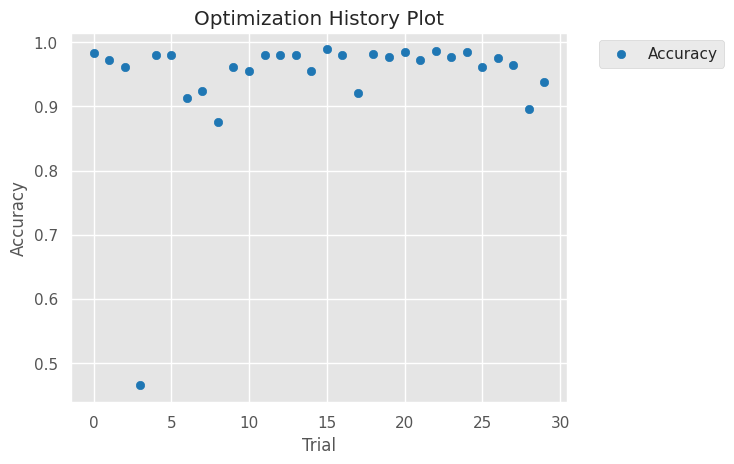

In [91]:
#objective - minus validation accuracy
optuna.visualization.matplotlib.plot_optimization_history(TPE_study, target=lambda t: -t.values[0], target_name='Accuracy')
plt.show()

In [76]:
plot_parallel_coordinate(TPE_study, target_name='Minus accuracy')

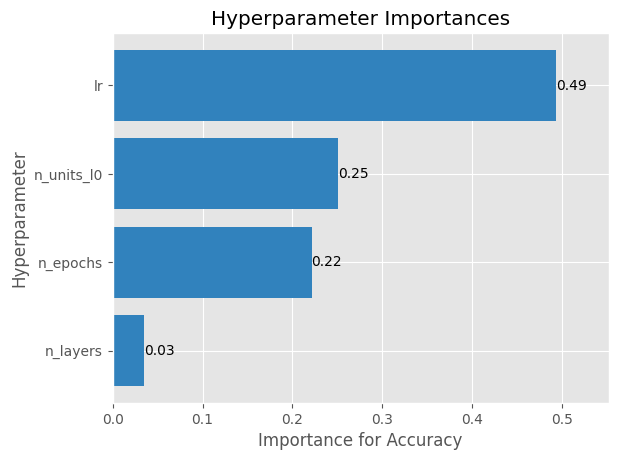

In [56]:
optuna.visualization.matplotlib.plot_param_importances(TPE_study, target_name='Accuracy')
plt.show()

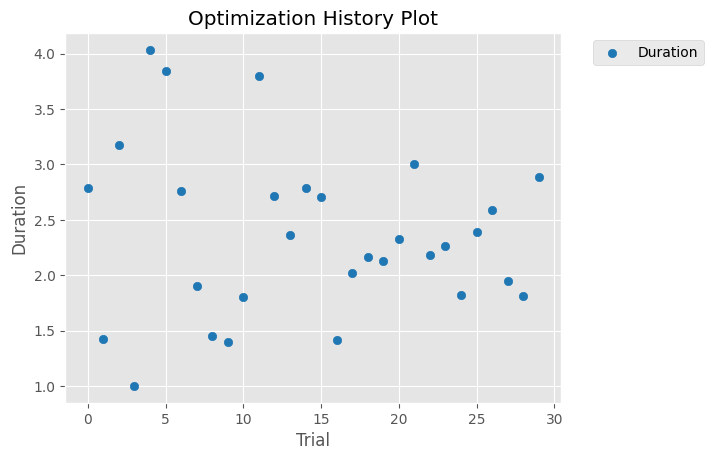

In [57]:
#objective - duration
optuna.visualization.matplotlib.plot_optimization_history(TPE_study, target=lambda t: t.duration.total_seconds(), target_name='Duration')
plt.show()

### TPE with inference time

In [ ]:
TPEps_study = optuna.create_study(sampler=TPESamplerWithPS(), directions=["minimize", "minimize"])
TPEps_study.optimize(objective_with_time, n_trials=30, timeout=300)

In [59]:
#best parameters
best_accuracy_idx = np.argmin([trial.values[0] for trial in TPEps_study.trials])
TPEps_study.trials[best_accuracy_idx].params

{'lr': 0.0013398269899832617,
 'n_epochs': 28,
 'n_layers': 3,
 'n_units_l0': 81,
 'n_units_l1': 99,
 'n_units_l2': 77}

In [60]:
accuracy, inf_time = TPEps_study.trials[best_accuracy_idx].values
print('Best accuracy:', -accuracy)
print('Corresponding inference time:', inf_time)

Best accuracy: 0.9907407164573669
Corresponding inference time: 0.3630707263946533


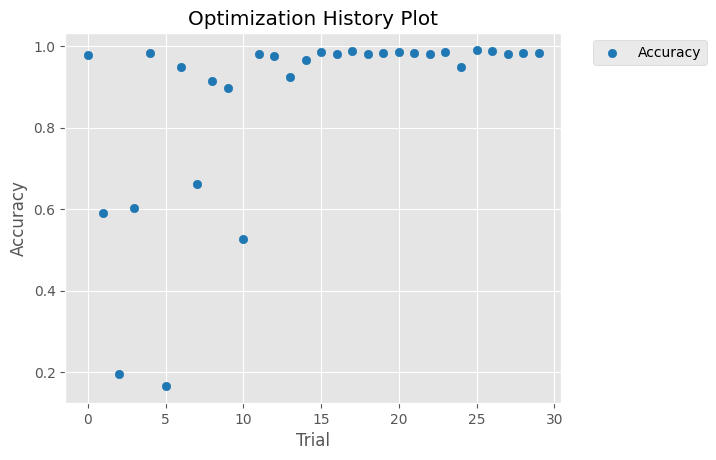

In [73]:
#objective - accuracy
optuna.visualization.matplotlib.plot_optimization_history(TPEps_study, target=lambda t: -t.values[0], target_name='Accuracy')
plt.show()

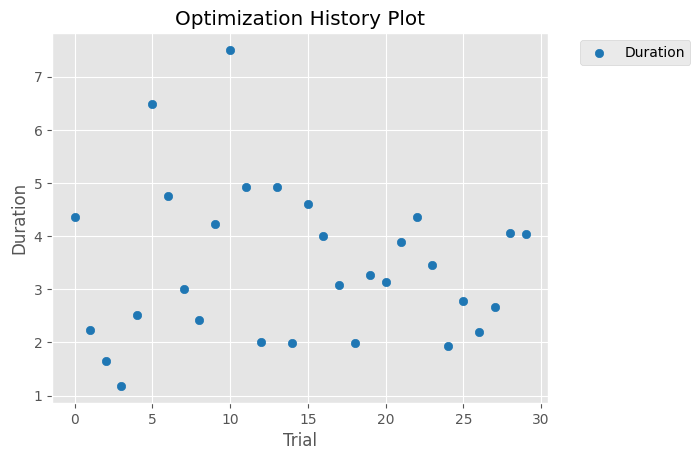

In [64]:
optuna.visualization.matplotlib.plot_optimization_history(TPEps_study, target=lambda t: t.duration.total_seconds(), target_name='Duration')
plt.show()

In [68]:
optuna.visualization.plot_pareto_front(TPEps_study, target_names=["Minus accuracy", "inference time"])

### TPE with Pareto front

In [ ]:
Pareto_study = optuna.create_study(directions=["minimize", "minimize"])
Pareto_study.optimize(objective_with_time, n_trials=30, timeout=300)

In [70]:
#best parameters
best_accuracy_idx = np.argmin([trial.values[0] for trial in Pareto_study.trials])
Pareto_study.trials[best_accuracy_idx].params

{'lr': 0.0031624115751451233,
 'n_epochs': 27,
 'n_layers': 3,
 'n_units_l0': 124,
 'n_units_l1': 91,
 'n_units_l2': 128}

In [71]:
accuracy, time = Pareto_study.trials[best_accuracy_idx].values
print('Best accuracy:', -accuracy)
print('Corresponding inference time:', time)

Best accuracy: 0.9925925731658936
Corresponding inference time: 0.38774561882019043


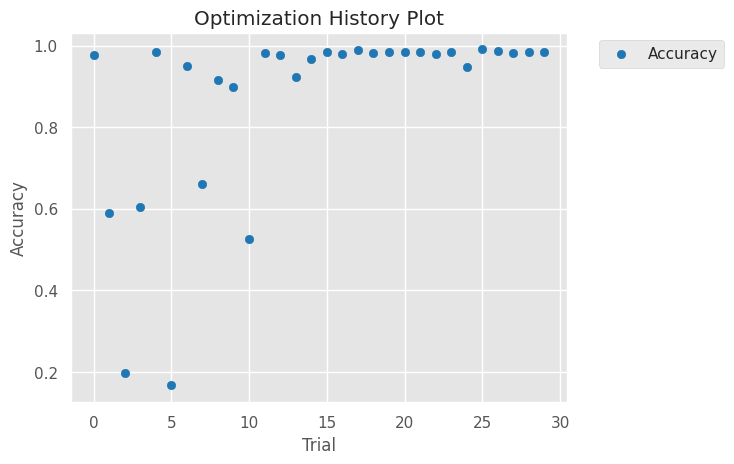

In [100]:
#objective - accuracy
optuna.visualization.matplotlib.plot_optimization_history(TPEps_study, target=lambda t: -t.values[0], target_name='Accuracy')
plt.show()

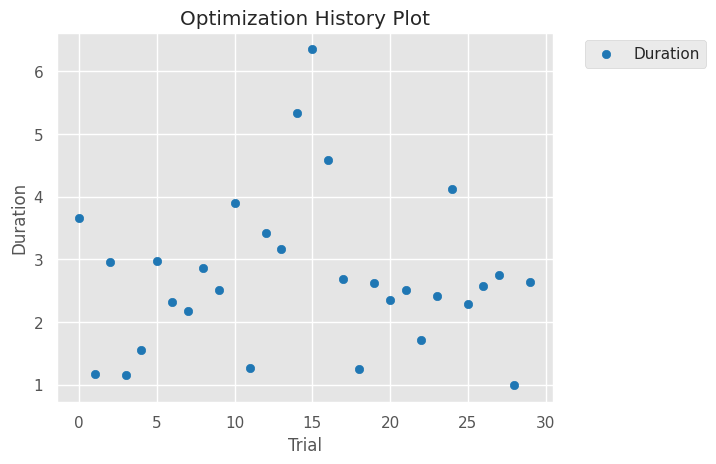

In [99]:
optuna.visualization.matplotlib.plot_optimization_history(Pareto_study, target=lambda t: t.duration.total_seconds(), target_name='Duration')
plt.show()

In [72]:
optuna.visualization.plot_pareto_front(Pareto_study, target_names=["Minus accuracy", "inference time"])

### Visualization

In [78]:
from optuna.visualization._optimization_history import _get_optimization_history_info_list

In [96]:
%matplotlib inline

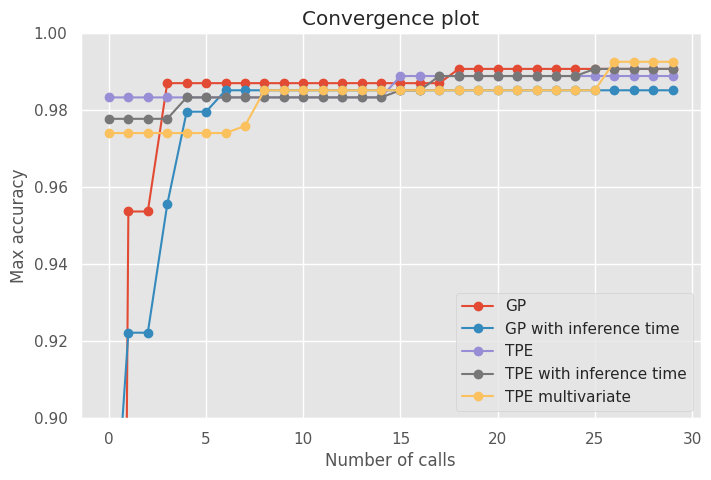

In [98]:
plt.figure(figsize=(8, 5))

num_calls = 30
plt.plot(np.arange(num_calls), -np.minimum.accumulate(gp_res.func_vals), marker='o', label='GP')
plt.plot(np.arange(num_calls), -np.minimum.accumulate(EIps_res.func_vals), marker='o', label='GP with inference time')
TPE_res = _get_optimization_history_info_list(TPE_study, None, "Objective Value", False)[0].values_info.values
plt.plot(np.arange(num_calls), -np.minimum.accumulate(TPE_res), marker='o', label='TPE')
TPEps_res = _get_optimization_history_info_list(TPEps_study, lambda t: t.values[0], "Objective Value", False)[0].values_info.values
plt.plot(np.arange(num_calls), -np.minimum.accumulate(TPEps_res), marker='o', label='TPE with inference time')
Pareto_res = _get_optimization_history_info_list(Pareto_study, lambda t: t.values[0], "Objective Value", False)[0].values_info.values
plt.plot(np.arange(num_calls), -np.minimum.accumulate(Pareto_res), marker='o', label='TPE multivariate')
plt.legend()
plt.title('Convergence plot')
plt.xlabel('Number of calls')
plt.ylabel('Max accuracy')
plt.ylim([0.9, 1])
plt.show()

Выводы

1. TPE показало результаты немного лучше, чем GP
2. Сейчас на качество значительно влияет learning rate. Для более аккуратного подбора структуры следует сузить границы для оптимизационных гиперпараметров
3. При учёте в модели временных затрат на валидации время инференса оптимальной модели не сократилось. Однако, используя Парето-фронт можно подобрать быструю модель с небольшой потерей качества